In [1]:
import os
import yaml
import sys
import datetime
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
date_str = re.sub(r' |:|\.', r'_', str(datetime.datetime.today()))
date_str

'2024-02-06_13_59_55_158025'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/htan_talk'
mushroom_dir = os.path.join(run_dir, f'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps = [fp for fp in config_fps if 'wandb' not in fp]
config_fps

['/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_16_39_25_636084/outputs/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_18_03_24_580462/outputs/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml']

In [8]:
config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(mushroom_dir, f'{case}_{date_str}', 'outputs')

Path(out_dir).mkdir(parents=True, exist_ok=True)                       

sections_config = yaml.safe_load(open(config_fp))

sections_config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s0_he.tif'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s1_he.tif'}],
  'id': 's1',
  'position': 20},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 25},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 30},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s4_he.tif'}],
  'id': 's4',
  'position': 45},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad'}],
  'id':

In [9]:
# one of the xenium sections is detached
sections_config = [entry for entry in sections_config if 's19'!=entry['id']]

In [10]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [11]:
mushroom_config = {
    'sections': sections_config,
    'dtype_to_chkpt': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 128,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'he': (256, 128, 10,), 'visium': (256, 512, 2048,), 'xenium': (256, 256, 256,), 'cosmx': (256, 512, 1024,)},
        'recon_scaler': 1.,
        'neigh_scaler': .01,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 1.,
        'target_ppm': .02, # 50 microns per tile
        'contrast_pct': None,
        'pct_expression': .05,
        'batch_size': 128,
        'num_workers': 1,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 5,
        'steps_per_epoch': 200,
#         'max_epochs': 1,
#         'steps_per_epoch': 1000,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'out_dir': out_dir,
        'save_every': 1,
        'log_every_n_steps': 10,
        'logger_type': 'wandb',
        'logger_project': f'{case}_{date_str}',
    },
}

In [12]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:loading spore for cosmx
INFO:root:starting cosmx processing
INFO:root:using 1000 channels
INFO:root:2 sections detected: ['s8', 's21']
INFO:root:processing sections
INFO:root:generating image data for section s8
INFO:root:generating image data for section s21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('s8', 'cosmx'), ('s21', 'cosmx')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpwz6p7sdq
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpwz6p7sdq/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for he
INFO:root:starting he processing
INFO:root:13 sections detected: ['s0', 's1', 's4', 's7', 's9', 's11', 's12', 's13', 's16', 's17', 's22', 's25', 's26']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s9
INFO:root:generating image data for section s11
INFO:root:generating image data for section s12
INFO:root:generating image data for section s13
INFO:root:generating image data for section s16
INFO:root:generating image data for section s17
INFO:root:generating image data for section s22
INFO:root:generating image data for section s25
INFO:root:generating image data for section s26
INFO:root:genera

In [13]:
mushroom.section_ids

[('s0', 'he'),
 ('s1', 'he'),
 ('s2', 'xenium'),
 ('s3', 'multiplex'),
 ('s4', 'he'),
 ('s5', 'xenium'),
 ('s6', 'multiplex'),
 ('s7', 'he'),
 ('s8', 'cosmx'),
 ('s9', 'he'),
 ('s10', 'xenium'),
 ('s11', 'he'),
 ('s12', 'he'),
 ('s13', 'he'),
 ('s14', 'xenium'),
 ('s15', 'multiplex'),
 ('s16', 'he'),
 ('s17', 'he'),
 ('s19', 'xenium'),
 ('s20', 'multiplex'),
 ('s21', 'cosmx'),
 ('s22', 'he'),
 ('s23', 'xenium'),
 ('s24', 'multiplex'),
 ('s25', 'he'),
 ('s26', 'he'),
 ('s27', 'multiplex'),
 ('s28', 'multiplex')]

In [14]:
mushroom.train()

INFO:root:starting training for cosmx
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 6.7 M 
------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.969    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:root:finished training cosmx, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-02-06_13_59_55_158025/outputs/cosmx_chkpts/last.ckpt
INFO:root:starting training for he
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.874    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-02-06_13_59_55_158025/outputs/he_chkpts/last.ckpt
INFO:root:starting training for multiplex
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.918    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-02-06_13_59_55_158025/outputs/multiplex_chkpts/last.ckpt
INFO:root:starting training for xenium
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.993    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-02-06_13_59_55_158025/outputs/xenium_chkpts/last.ckpt


In [16]:
mushroom.embed_sections()

INFO:root:embedding cosmx spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [17]:
spore = mushroom.dtype_to_spore['cosmx']
spore.true_pixels[0].shape

(100, 76, 1000)

In [18]:
img = spore.true_pixels[0]
img.shape

(100, 76, 1000)

In [19]:
(img > 0).sum(-1).shape

(100, 76)

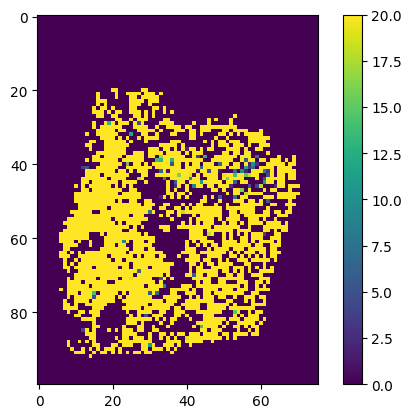

In [21]:
plt.imshow((img > 0).sum(-1), vmax=20)
plt.colorbar()

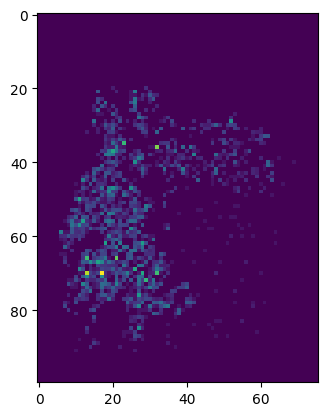

In [39]:
img = spore.true_pixels[0][..., spore.dtype_to_channels['cosmx'].index('EPCAM')]
plt.imshow(img)

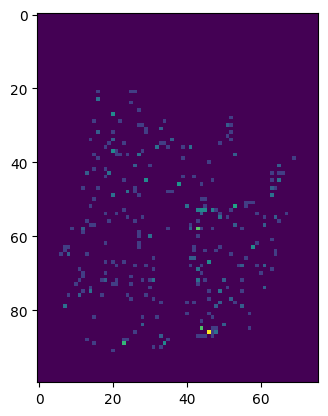

In [48]:
img = spore.true_pixels[0][..., spore.dtype_to_channels['cosmx'].index('IL7R')]
plt.imshow(img)

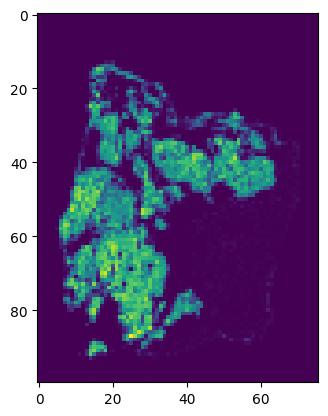

In [46]:
img = mushroom.dtype_to_spore['xenium'].true_pixels[0][..., mushroom.dtype_to_spore['xenium'].dtype_to_channels['xenium'].index('EPCAM')]
plt.imshow(img)

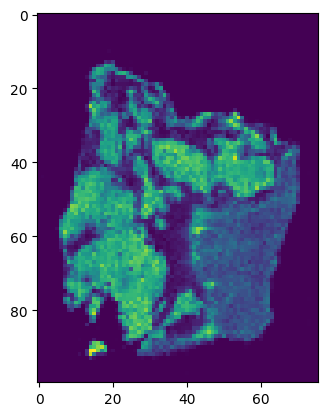

In [43]:
img = mushroom.dtype_to_spore['xenium'].true_pixels[0].sum(-1)
plt.imshow(img)

In [ ]:
img = spore.true_pixels[0].sum(-1)
plt.imshow(img)

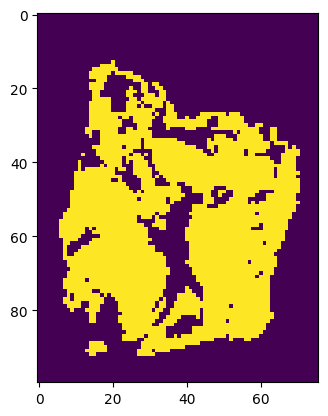

In [44]:
plt.imshow(img > 10)

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume


nhwa,nhwb,nhwc,nhwd->nhwabcd [torch.Size([30, 100, 76, 7]), torch.Size([30, 100, 76, 8]), torch.Size([30, 100, 76, 8]), torch.Size([30, 100, 76, 8])]
torch.Size([30, 100, 76, 7, 8, 8, 8])


INFO:root:finished integration, found 14 clusters


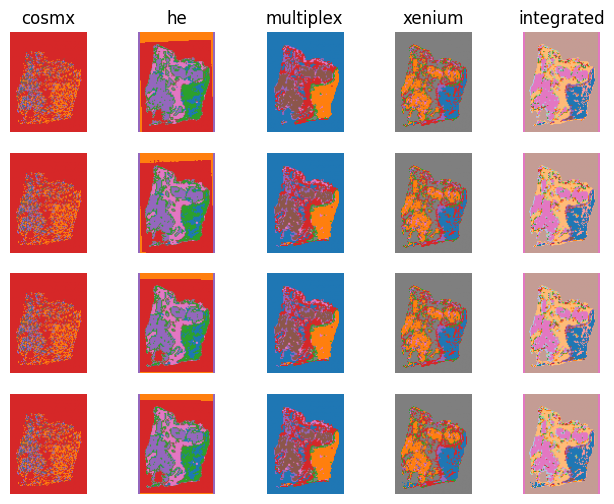

In [24]:
level = 0
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.,
    'cosmx': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4, kernel_size=None)
mushroom.display_volumes(positions=[5,6,7,8], figsize=(8, 6))

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 8058 nodes
INFO:root:0 of 8058 nodes processed
INFO:root:1000 of 8058 nodes processed
INFO:root:2000 of 8058 nodes processed
INFO:root:3000 of 8058 nodes processed
INFO:root:4000 of 8058 nodes processed
INFO:root:5000 of 8058 nodes processed
INFO:root:6000 of 8058 nodes processed
INFO:root:7000 of 8058 nodes processed
INFO:root:8000 of 8058 nodes processed
INFO:root:finished integration, found 27 clusters


CPU times: user 17min 51s, sys: 9min 53s, total: 27min 44s
Wall time: 3min 46s


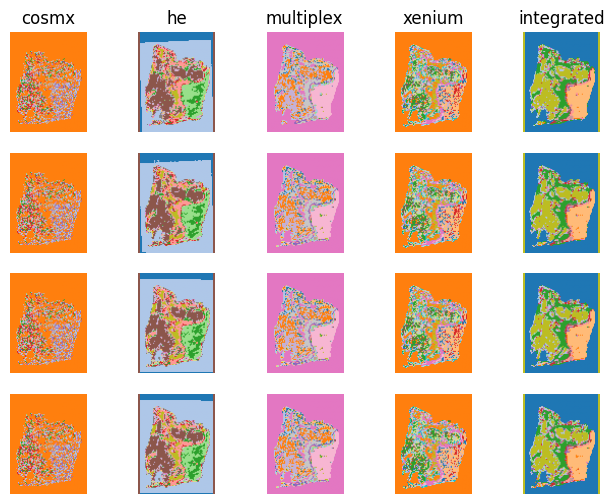

In [83]:
%%time
level = 1
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.,
    'cosmx': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4, kernel_size=None)
mushroom.display_volumes(positions=[5,6,7,8], figsize=(8, 6))

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 11697 nodes
INFO:root:0 of 11697 nodes processed
INFO:root:1000 of 11697 nodes processed
INFO:root:2000 of 11697 nodes processed
INFO:root:3000 of 11697 nodes processed
INFO:root:4000 of 11697 nodes processed
INFO:root:5000 of 11697 nodes processed
INFO:root:6000 of 11697 nodes processed
INFO:root:7000 of 11697 nodes processed
INFO:root:8000 of 11697 nodes processed
INFO:root:9000 of 11697 nodes processed
INFO:root:10000 of 11697 nodes processed
INFO:root:11000 of 11697 nodes processed
INFO:root:11697 of 11697 nodes processed
INFO:root:finished integration, found 29 clusters


CPU times: user 31min 48s, sys: 36min 4s, total: 1h 7min 53s
Wall time: 8min 51s


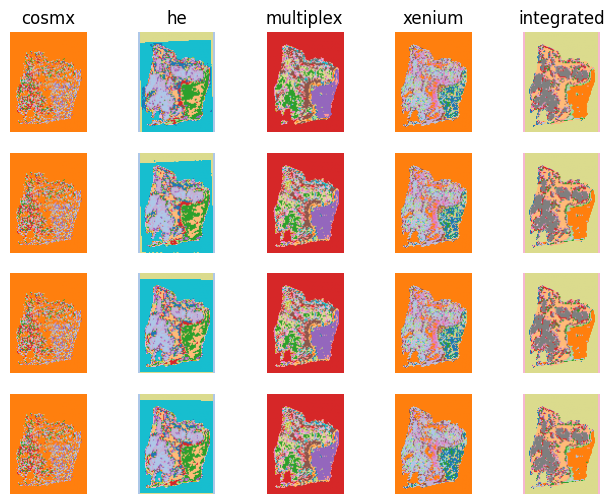

In [84]:
%%time
level = 2
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.,
    'cosmx': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4, kernel_size=None)
mushroom.display_volumes(positions=[5,6,7,8], figsize=(8, 6))

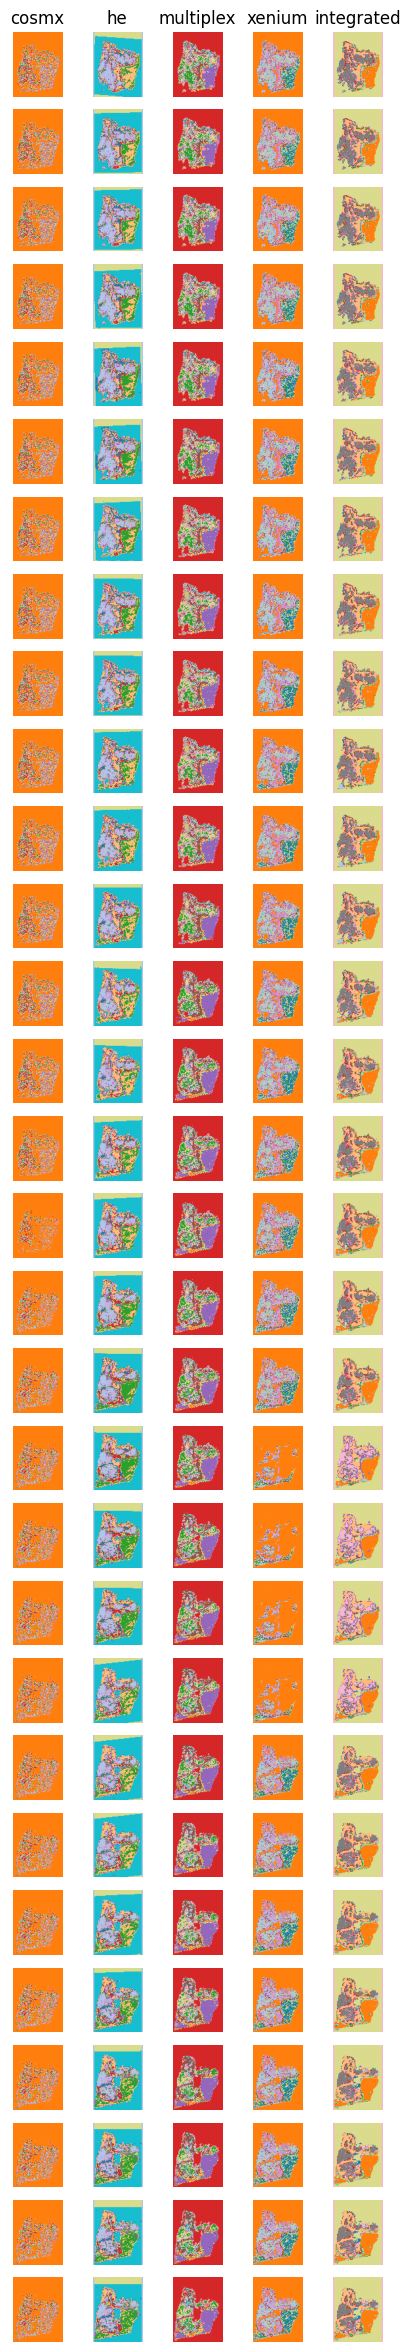

In [85]:
mushroom.display_volumes()

In [86]:
dtype_to_df = mushroom.calculate_cluster_intensities(use_integrated=False)
dtype_to_df['xenium']

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.494894,0.256299,0.339620,0.299193,0.316098,0.144658,0.437903,1.010322,0.264805,0.514037,...,0.037694,0.061377,-0.005371,0.072193,0.119039,0.526760,0.089554,0.928014,0.287497,0.828328
1,-0.063085,-0.227615,-0.156699,-0.096495,-0.014544,-0.248547,-0.138630,-0.133410,-0.131714,-0.248334,...,0.134990,-0.120988,-0.112625,0.235743,-0.313781,-0.048012,-0.137814,-0.045064,-0.299204,-0.156227
2,-0.177731,-0.227599,-0.310304,-0.302836,-0.423297,-0.550972,-0.452050,-0.421041,-0.352311,-0.480954,...,-0.409706,-0.226970,-0.178752,-0.480274,-0.517770,-0.596877,-0.265050,-0.436848,-0.459554,-0.396729
3,0.424936,0.021153,0.277943,0.236912,0.143703,0.020890,0.239139,0.743486,0.183082,0.258112,...,0.088311,0.046714,-0.046941,0.038871,-0.003286,0.312204,0.047131,0.776072,0.099989,0.572538
4,0.291865,0.280527,0.278298,0.308419,0.463300,0.313090,0.616657,0.830918,0.396340,0.535359,...,0.344719,0.175737,0.058670,0.402230,0.234406,0.761770,0.181871,0.752052,0.289504,0.643272
5,0.342534,0.013705,0.170855,0.149910,0.146907,-0.026689,0.189690,0.577530,0.123307,0.193970,...,0.093975,0.022660,-0.019221,0.157152,-0.074026,0.279386,0.004030,0.587268,0.049411,0.431284
6,0.302998,0.566283,0.307215,0.364439,1.015025,0.342193,0.980891,1.345613,0.433472,0.868706,...,0.513669,0.171366,0.048588,0.902459,0.175679,1.335724,0.260502,1.079665,0.412987,0.982791
7,-0.079873,-0.036054,-0.025482,0.035495,0.177400,0.187679,0.196923,-0.072334,0.254653,-0.032837,...,0.401335,0.083212,-0.098002,0.666950,0.049141,0.470462,0.095145,0.022806,-0.066952,0.107286
8,0.077283,0.433554,0.162330,0.251007,1.032011,0.418711,0.925592,0.916438,0.433502,0.737892,...,0.755104,0.181691,0.032745,1.269275,0.232384,1.361539,0.210306,0.791567,0.350944,0.651470
9,-0.036294,0.027803,-0.129382,-0.060509,0.824851,-0.183776,0.428912,0.541868,-0.035937,0.082176,...,0.828425,-0.092418,-0.058996,1.309707,-0.339770,0.851830,-0.068741,0.383324,-0.119732,0.197014


In [87]:
dtype_to_df = mushroom.calculate_cluster_intensities(use_integrated=True, level=1)
dtype_to_df['xenium']

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,-0.149373,-0.205682,-0.268148,-0.258016,-0.378467,-0.508270,-0.403264,-0.363430,-0.302245,-0.423481,...,-0.367265,-0.201021,-0.158629,-0.432702,-0.467805,-0.541002,-0.240079,-0.378136,-0.417897,-0.339795
1,0.158686,0.346783,0.579431,0.432826,0.499744,1.085273,0.637701,0.372814,0.575141,0.736144,...,0.562303,0.403733,0.356318,0.559675,1.102377,0.758677,0.458213,0.420061,0.854531,0.408096
2,0.332033,-0.032656,0.205052,0.148958,0.010245,-0.010173,0.076116,0.402048,0.112736,0.109937,...,-0.018532,0.018593,-0.000152,-0.139529,-0.046775,0.113620,0.040170,0.533860,0.002665,0.384917
3,0.371319,-0.138389,0.195394,0.101909,-0.206907,-0.116261,-0.115913,0.269475,0.021568,-0.034502,...,-0.198159,-0.036069,-0.020563,-0.423702,-0.129544,-0.163871,-0.025431,0.448318,-0.082266,0.304065
4,-0.069223,-0.050108,-0.102487,-0.078480,0.223502,-0.163730,0.074974,0.098687,-0.066201,-0.068742,...,0.247326,-0.094783,-0.061085,0.441666,-0.229159,0.201928,-0.077513,0.043099,-0.149203,-0.022218
5,-0.012989,0.043955,0.040949,0.046787,0.335525,0.089990,0.242170,0.206452,0.095874,0.116714,...,0.367204,0.023520,0.016109,0.552693,0.033886,0.400049,0.058578,0.177346,0.046048,0.111347
6,0.062677,0.314804,0.146344,0.158306,0.739528,0.332613,0.628779,0.669610,0.258964,0.524819,...,0.530847,0.103189,0.073484,0.912642,0.212903,0.924202,0.169865,0.558960,0.287344,0.461593
7,0.208216,0.223894,0.166972,0.167161,0.492543,0.151380,0.458193,0.689791,0.198338,0.412805,...,0.270925,0.063445,0.028054,0.471698,0.043303,0.669496,0.110308,0.651578,0.154295,0.519524
8,0.153436,0.816500,0.309752,0.306068,1.343174,0.841317,1.195870,1.314922,0.465558,1.249159,...,0.718110,0.239664,0.184018,1.359040,0.607723,1.670292,0.313149,1.013131,0.790886,0.960319
9,-0.053456,-0.036149,-0.075339,-0.058025,0.141269,-0.116551,0.047829,0.041657,-0.040762,-0.051250,...,0.160832,-0.063560,-0.054410,0.295997,-0.162315,0.128379,-0.051799,0.022068,-0.121637,-0.021119


In [88]:
prefix = os.path.join(out_dir, f'clusters')
for dtype in mushroom.dtype_to_volume.keys():
    for i in range(3):
        root = prefix + f'_{dtype}_axis{i}'
        is_probs = False
        volume = mushroom.dtype_to_volume[dtype]
        vis_utils.volume_to_gif(volume, is_probs, root + '_section.gif', axis=i)
        
        if i in [1, 2]:
            rgb = vis_utils.display_labeled_as_rgb(volume[0], preserve_indices=True)
            vis_utils.save_reference_gif(rgb, root + '_ref.gif', axis=i-1)
        
        

In [89]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-02-06_13_59_55_158025/outputs


In [252]:
new = Mushroom.from_config(
    '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs/config.yaml',
    accelerator='cpu'
)

INFO:root:loading spore for he
INFO:root:starting he processing
INFO:root:14 sections detected: ['s0', 's1', 's4', 's7', 's8', 's10', 's11', 's12', 's15', 's16', 's17', 's20', 's23', 's24']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s10
INFO:root:generating image data for section s11
INFO:root:generating image data for section s12
INFO:root:generating image data for section s15
INFO:root:generating image data for section s16
INFO:root:generating image data for section s17
INFO:root:generating image data for section s20
INFO:root:generating image data for section s23
INFO:root:generating image data for section s24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detec

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

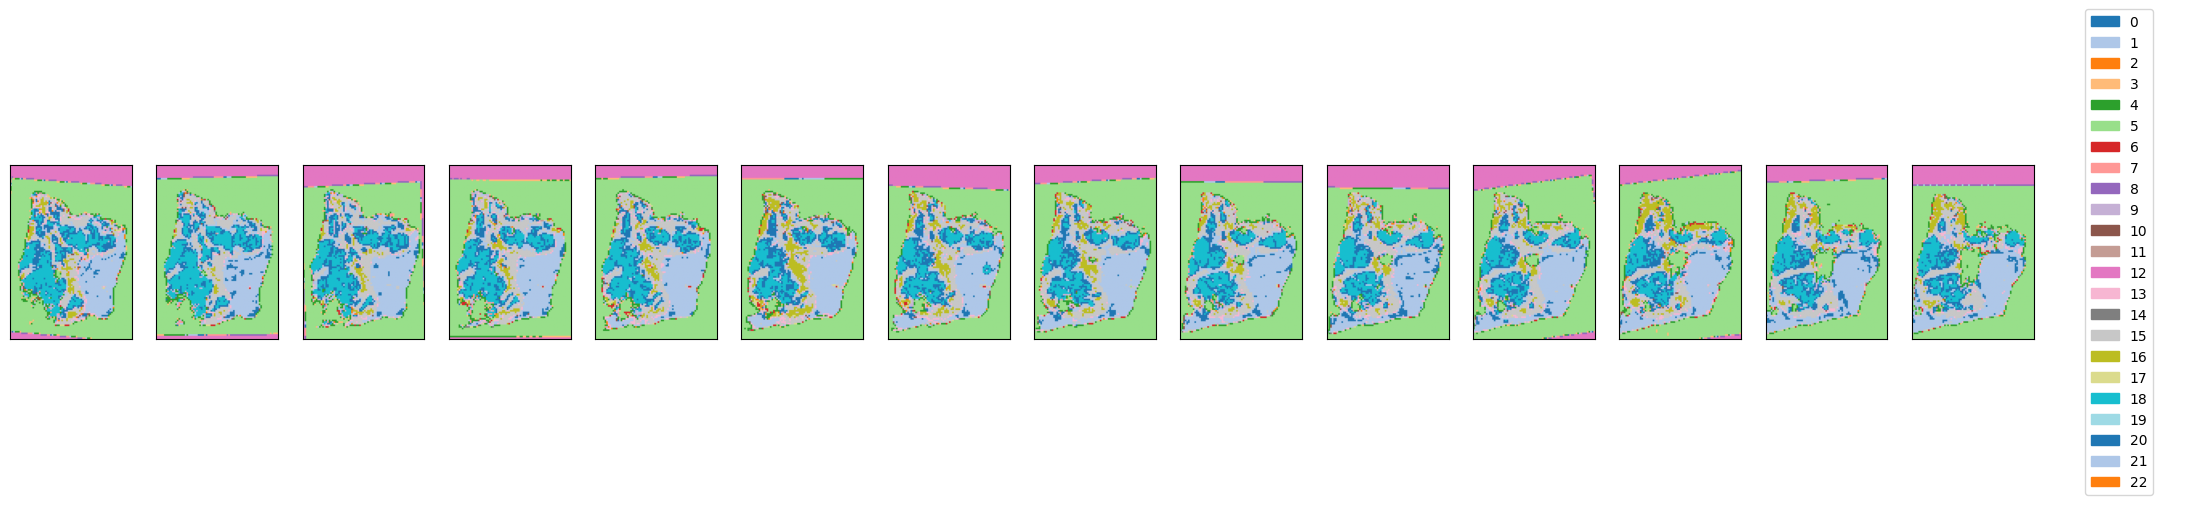

In [253]:
new.display_clusters('he')